Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pickle
import pandas as pd
import random
import cv2


In [ ]:
# Read data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/german-traffic-signs/signnames.csv")

with open('/content/drive/MyDrive/Colab Notebooks/german-traffic-signs/train.p', 'rb') as f:
	train_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/german-traffic-signs/valid.p', 'rb') as f:
	val_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/german-traffic-signs/test.p', 'rb') as f:
	test_data = pickle.load(f)

# Extracting the labels from the dictionaries
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Printing the shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


Preprocessing using OpenCV


*   First, the images are converted to grayscale images for reducing computation using the cvtColor() function.

*   The equalizeHist() function increases the contrasts of the image by equalizing the intensities of the pixels by normalizing them with their nearby pixels.
 
*   At the end, we normalize the pixel values between 0 and 1 by dividing them by 255.



In [ ]:
def preprocessing(img):
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	img = cv2.equalizeHist(img)
	img = img / 255
	return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


Augmentation

In [ ]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
				height_shift_range = 0.1,
				zoom_range = 0.2,
				shear_range = 0.1,
				rotation_range = 10)
datagen.fit(X_train)

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)


Building the Model

In [ ]:
num_classes = 43

def cnn_model():
	model = Sequential()
	model.add(Conv2D(60, (5, 5),
					input_shape =(32, 32, 1),
					activation ='relu'))
	
	model.add(Conv2D(60, (5, 5), activation ='relu'))
	model.add(MaxPooling2D(pool_size =(2, 2)))
	
	model.add(Conv2D(30, (3, 3), activation ='relu'))
	model.add(Conv2D(30, (3, 3), activation ='relu'))
	model.add(MaxPooling2D(pool_size =(2, 2)))
	
	model.add(Flatten())
	model.add(Dense(500, activation ='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation ='softmax'))
	
	# Compile model
	model.compile(Adam(lr = 0.001),
				loss ='categorical_crossentropy',
				metrics =['accuracy'])
	return model

model = cnn_model()
history = model.fit_generator(datagen.flow(X_train, y_train,
							batch_size = 32), steps_per_epoch = 550,
							epochs = 10, validation_data =(X_val, y_val),
							shuffle = 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
550/550 [==============================] - 150s 272ms/step - loss: 2.9025 - accuracy: 0.2189 - val_loss: 0.5474 - val_accuracy: 0.8345
Epoch 2/10
550/550 [==============================] - 150s 272ms/step - loss: 0.9983 - accuracy: 0.6951 - val_loss: 0.2316 - val_accuracy: 0.9324
Epoch 3/10
550/550 [==============================] - 150s 272ms/step - loss: 0.5871 - accuracy: 0.8214 - val_loss: 0.1350 - val_accuracy: 0.9578
Epoch 4/10
550/550 [==============================] - 149s 271ms/step - loss: 0.4336 - accuracy: 0.8637 - val_loss: 0.0856 - val_accuracy: 0.9728
Epoch 5/10
550/550 [==============================] - 149s 271ms/step - loss: 0.3589 - accuracy: 0.8907 - val_loss: 0.0904 - val_accuracy: 0.9723
Epoch 6/10
550/550 [==============================] - 149s 271ms/step - loss: 0.3022 - accuracy: 0.9038 - val_loss: 0.0682 - val_accuracy: 0.9800
Epoch 7/10
550/550 [==============================] - 149s 271ms/step - loss: 0.2551 - accuracy: 0.9193 - val_loss: 0.0932 -

Plotting Loss Function

Text(0.5, 0, 'epoch')

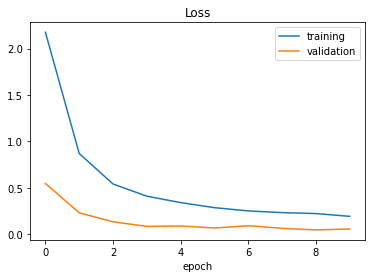

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


Plotting Accuracy

Text(0.5, 0, 'epoch')

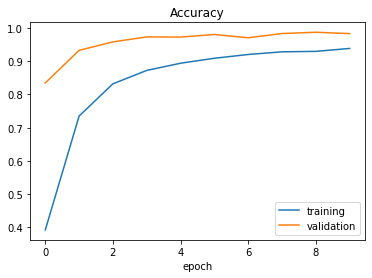

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')


In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])


Test Loss:  0.15280142426490784
Test Accuracy:  0.9559778571128845


Checking one test image by feeding it into the model. The model gives a prediction of class 0 (Speed limit 20), which is correct.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted sign: [0]


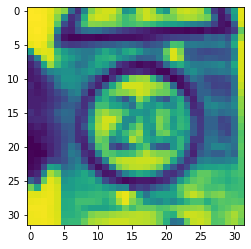

In [ ]:
plt.imshow(X_test[990].reshape(32, 32))
print("Predicted sign: "+ str(
		model.predict_classes(X_test[990].reshape(1, 32, 32, 1))))
